In [6]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import sys
sys.path.append('/app')
sys.path.append('..')
import json
import toml
import datetime
import wandb
import argparse
# from accelerate import Accelerator

from utils.data_utils import read_hdf
from dataloaders.deeponet_dataloader import SimpleDataset, get_cr_dirs
from utils.gif_generator import create_gif_from_array 
from utils.save_summary import save_summary
from utils.losses import L2OperatorLoss
from neuralop import LpLoss
from src.DeepONet.trainer import train, save_training_results_artifacts
from model import make_deeponet
import math


ngpu      = 0

with open('/app/src/DeepONet/config.toml', 'r') as f:
    config = toml.load(f)

DATA_DIR = config['train_params']['data_dir']
BASE_DIR = config['train_params']['base_dir']
batch_size = config['train_params']['batch_size']
n_epochs = config['train_params']['n_epochs']
lr = config['train_params']['lr']

model_type = config['model_params']['model_type']
scale_up = config['model_params']['scale_up']
loss_fn_str = config['model_params']['loss_fn']
pos_embedding = config['model_params']['pos_embedding']
trunk_sample_size = config['model_params']['trunk_sample_size']
branch_layers = config['model_params'].get('branch_layers', [128,128,128,128])
trunk_layers = config['model_params'].get('trunk_layers', [128,128,128,128])

wandb_run_name = config['wandb_params']['run_name']
wandb_group_name = config['wandb_params']['group_name'] 
enable_wandb_logging = config['wandb_params']['enable_wandb_logging']

job_id = datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")
if pos_embedding == False:
    pos_embedding = None

cr_dirs = get_cr_dirs(DATA_DIR)
split_ix = int(len(cr_dirs) * 0.8)
# cr_train, cr_test = cr_dirs[:split_ix], cr_dirs[split_ix:]
cr_train, cr_test = cr_dirs[:32], cr_dirs[32:64]

In [20]:
class DeepONetDataset(SimpleDataset):
    def __init__(
        self,
        data_path,
        cr_list,
        v_min=None,
        v_max=None,
        instruments=None,
        scale_up=1,
        pos_embedding = None,
        trunk_sample_size=32768,
    ):
        super().__init__(
            data_path=data_path,
            cr_list=cr_list,
            v_min=v_min,
            v_max=v_max,
            instruments=instruments,
            scale_up=1,
            pos_embedding=pos_embedding,
        )
        self.trunk_sample_size = trunk_sample_size
        # self.sim_paths = collect_sim_paths(data_path, cr_list, instruments)
        # sims, _ = get_sims(self.sim_paths, scale_up, pos_embedding)
        # sims, self.v_min, self.v_max = min_max_normalize(sims, v_min, v_max)
        # self.sims = sims
        # self.climatology = compute_climatology(sims[:, 0, 1:, :, :], scale_up)
        # print(self.sims.shape)
        self.window_start = 2
        self.window_step = 3
        self.num_windows = math.ceil((self.sims.shape[2] - 2) / self.window_step)

    def __getitem__(self, index):
        cube = self.sims[index]
        self.window_end = min(self.window_start + self.window_step, cube.shape[1])
        u_surface = cube[:, 0, :, :]   # (C, H, W)
        y_target = cube[0, self.window_start:self.window_end, :, :] 

        # Flatten surface for branch input
        # u_surface = resize_3d(u_surface, u_surface.shape[1]//2, u_surface.shape[2]//2)
        branch_input = torch.tensor(u_surface, dtype=torch.float32).reshape(-1)[::4]
        
        # Fast random sampling of trunk points
        # nR, nH, nW = y_target.shape
        # idx_r = np.random.randint(0, nR, size=self.trunk_sample_size)
        # idx_h = np.random.randint(0, nH, size=self.trunk_sample_size)
        # idx_w = np.random.randint(0, nW, size=self.trunk_sample_size)

        # coords = np.stack([idx_r + 1, idx_h, idx_w], axis=-1).astype(np.float32)
        # target = y_target[idx_r, idx_h, idx_w].astype(np.float32)
        # trunk_input = torch.from_numpy(coords)
        # target = torch.from_numpy(target)

        # Full Grid for trunk input
        nR, nH, nW = y_target.shape
        maxR, maxH, maxW = cube.shape[1:]
        r = np.arange(self.window_start, self.window_end, dtype=np.float32)/ (maxR)
        h = np.arange(nH, dtype=np.float32) / (maxH)
        w = np.arange(nW, dtype=np.float32) / (maxW)
        # r = np.arange(self.window_start, window_end, dtype=np.float32)
        # h = np.arange(nH, dtype=np.float32)
        # w = np.arange(nW, dtype=np.float32)

        Rg, Hg, Wg = np.meshgrid(r, h, w, indexing="ij")

        coords = np.stack([Rg, Hg, Wg], axis=-1).reshape(-1, 3)      # (N,3)
        target = y_target.reshape(-1).astype(np.float32)            # (N,)

        trunk_input = torch.from_numpy(coords)    # (1, N, 3)
        target = torch.from_numpy(target)         # (1, N)

        return {
            "branch": branch_input,   # (H * W * C,)
            "trunk": trunk_input,     # (N, 3)
            "target": target,          # (N,)
            # "idx_r": idx_r,
            # "idx_h": idx_h,
            # "idx_w": idx_w,
        }
    def increment_window_start(self):
        self.window_start += self.window_step
    def reset_window_start(self):
        self.window_start = 2
    def __len__(self):
        return len(self.sims)

    def get_min_max(self):
        return {"v_min": float(self.v_min), "v_max": float(self.v_max)}

    def get_grid_points(self):
        return get_coords(self.sim_paths[0])

    def get_branch_input_dims(self):
        C, H, W = self.sims.shape[1], self.sims.shape[3], self.sims.shape[4]
        return (C * H * W)//4
        
    def get_trunk_input_dims(self):
        return 3  # r, theta, phi


In [21]:
train_dataset = DeepONetDataset(DATA_DIR, cr_train, scale_up=scale_up, pos_embedding=pos_embedding, trunk_sample_size=trunk_sample_size)   
test_dataset = DeepONetDataset(
    DATA_DIR,
    cr_test,
    scale_up=scale_up,
    v_min=train_dataset.v_min,
    v_max=train_dataset.v_max,
    pos_embedding=pos_embedding,
    trunk_sample_size=trunk_sample_size
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

Loading simulations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.60it/s]


In [15]:
# model = make_deeponet(train_dataset.get_branch_input_dims(), train_dataset.get_trunk_input_dims(), branch_hidden_layers=branch_layers, trunk_hidden_layers=trunk_layers, num_outputs=1).cpu()
model = make_deeponet(3552, train_dataset.get_trunk_input_dims(), branch_hidden_layers=branch_layers, trunk_hidden_layers=trunk_layers, num_outputs=1).cpu()
model.load_state_dict(torch.load('/data/solar_wind_pred_vignesh/DeepONet_v1/2025_12_12__193843/best_model.pt', map_location='cpu', weights_only=True))






<All keys matched successfully>

In [22]:
for batch in train_loader:
    u = batch["branch"].cpu()                                  # (B, C*H*W)   or (B, D_branch)
    coords = batch["trunk"].cpu()                               # (B, N, 3)    or sometimes (N, 3) broadcasted
    y_true = batch["target"].cpu() 
    
    B, N_points, _= coords.shape
    
    coords_flat = coords.reshape(-1, coords.shape[-1])    # [B*N_points, 3]
    u_repeat = u.repeat_interleave(N_points, dim=0)       # [B*N_points, D_branch]
    y_flat = y_true.reshape(-1, 1)                        # [B*N_points, 1]
    
    pred_flat = model((u_repeat, coords_flat))            # [B*N_points, 1]
    pred = pred_flat.view(B, N_points)
    
    real_y   = y_true * (train_dataset.v_max - train_dataset.v_min) + train_dataset.v_min
    real_pred= pred    * (train_dataset.v_max - train_dataset.v_min) + train_dataset.v_min
    real_y   = real_y * 481.3711
    real_pred= real_pred * 481.3711

In [25]:
reshape_y = real_y.reshape((-1,111,128))
reshape_pred = real_pred.reshape((-1,111,128)).detach().numpy()

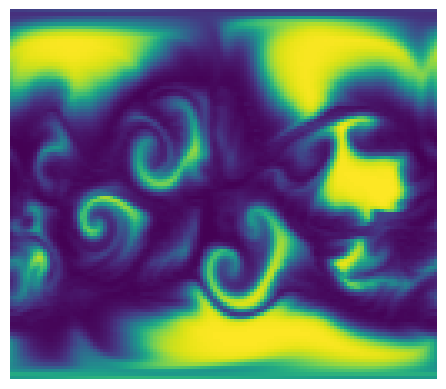

In [41]:
plt.imshow(reshape_y[1])
plt.axis('off')
plt.show()

In [ ]:
accelerator = Accelerator()
radii, thetas, phis = train_dataset.get_grid_points()

if loss_fn_str == "lp_loss":
    loss_fn = LpLoss(d=2, p=2)
elif loss_fn_str == "h1":
    loss_fn = H1LossSpherical(r_grid=radii[1:], theta_grid=thetas, phi_grid=phis)
elif loss_fn_str == "h1mae":
    loss_fn = H1LossSphericalMAE(r_grid=radii[1:], theta_grid=thetas, phi_grid=phis)
elif loss_fn_str == "mse":
    loss_fn = nn.MSELoss()
else:
    raise ValueError("unsupported loss function")

out_path = os.path.join(BASE_DIR, model_type, job_id)
os.makedirs(
    out_path,
    exist_ok=True,
)

run_params = {
    "run_name": wandb_run_name + '_' + job_id,
    "group_name": wandb_group_name,
}
wandb_params = {
    "num_epochs": n_epochs,
    "batch_size": batch_size,
    "learning_rate": lr,
    "train_files": cr_train,
    "test_files": cr_test,
    "v_min": float(train_dataset.v_min),
    "v_max": float(train_dataset.v_max),
    "loss_fn": loss_fn_str,
    "scale_up": scale_up,
    'weight_decay': 0.0,
    'job_id': job_id,
    'trunk_sample_size': trunk_sample_size,
    'branch_hidden_layers': branch_layers,
    'trunk_hidden_layers': trunk_layers,
}
with open(os.path.join(out_path, "cfg.json"), "w", encoding="utf-8") as f:
    json.dump(wandb_params, f)
    
if pos_embedding == 'pt':
    in_channels = 4
elif pos_embedding == 'ptr':
    raise ValueError('radii embedding is the same in full channel and is not supported here')
elif pos_embedding is None:
    in_channels = 1
else:
    raise ValueError('wrong pos embedding')

if accelerator.is_main_process:
    wandb.login()

model = make_deeponet(train_dataset.get_branch_input_dims(), train_dataset.get_trunk_input_dims(), branch_hidden_layers=branch_layers, trunk_hidden_layers=trunk_layers, num_outputs=1)

print('Branch input dims', train_dataset.get_branch_input_dims())
print('SIMS shape', train_dataset.sims[0].shape)

run = None
if enable_wandb_logging and accelerator.is_main_process:
    run = wandb.init(
        name=run_params['run_name'],
        group=run_params['group_name'],
        config=wandb_params
    )
    save_summary(os.path.join(out_path, "model_summary.txt"), model.branch, input_shape=(2, train_dataset.get_branch_input_dims()),)


In [ ]:
(
    training_results,
    best_epoch,
    best_state_dict,
) = train(
    model,
    train_dataset,
    test_dataset,
    loss_fn,
    accelerator=accelerator,
    run=run,
    wandb_params=wandb_params,
)
if accelerator.is_main_process:
    torch.save(best_state_dict, os.path.join(out_path, "best_model.pt"))
    if run is not None:
        artefact = wandb.Artifact(
            name='best_model',
            type='model',
            description='best model after training'
        )
        artifact.add_file(os.path.join(out_path, f"best_model.pt"))
        run.log_artifact(artifact)

    filename = f"best_epoch-{best_epoch}.txt"
    with open(
        os.path.join(out_path, filename), "w", encoding="utf-8"
    ) as f:
        f.write(f"best_epoch: {best_epoch}")
    if run is not None:
        artifact = wandb.Artifact(
            name='best_epoch',
            type='evaluation',
            description='epoch with lowest validation loss'
        )
        artifact.add_file(os.path.join(out_path, filename))
        run.log_artifact(artifact)

    save_training_results_artifacts(run, out_path, training_results)

    print("Training completed.")
    wandb.finish()